## EE526 Project
Group Members:
- Roop Sagar MANGINENI, #948529640
- Sohan Salhuddin MUGDHO, #939708824
- Sri Harsha MUDUMBA, #462988584

The dataset is available [Here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). The basic codes are references from the notebook [chest-x-ray-classification-with-transfer-learning](https://www.kaggle.com/code/minaemil329/chest-x-ray-classification-with-transfer-learning), while some code snippets are modified from chatgpt. Those codes are have comments mentioning this. This notebook has been run on Kaggle with P100 GPU. Normal colab does not provide enough RAM and GPU memory to run all the codes.

In [1]:
# installing gdown to download dataset
!pip install gdown

In [2]:
# downloading dataset, the id below is in working condition.
!gdown --id 1nzL9AR0JYTwSKzqTOr6Z8LyyON6FaIRx

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1nzL9AR0JYTwSKzqTOr6Z8LyyON6FaIRx
From (redirected): https://drive.google.com/uc?id=1nzL9AR0JYTwSKzqTOr6Z8LyyON6FaIRx&confirm=t&uuid=62d8524a-cd46-41ff-97ee-4b6241c7ae14
To: /kaggle/working/archive.zip
100%|██████████████████████████████████████| 2.46G/2.46G [00:41<00:00, 59.4MB/s]


In [3]:
# unzipping the dataset
!unzip -q /kaggle/working/archive.zip
!rm /kaggle/working/archive.zip

In [4]:
#  importing necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import random
import zipfile
import warnings
warnings.filterwarnings("ignore")






# improve visualization
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [65]:
dir_train = '/kaggle/working/chest_xray/chest_xray/train'
dir_valid = '/kaggle/working/chest_xray/chest_xray/val'
dir_test = '/kaggle/working/chest_xray/chest_xray/test'

labels = ['NORMAL', 'PNEUMONIA'] # creating the labels
dataset_train = []
dataset_valid = []
dataset_test = []

def load_train_dataset(): # creating function to load dataset_train
  for label in labels:
    path = os.path.join(dir_train, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_COLOR)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_train.append([resize_img, class_num])
      except Exception as e:
        pass

def load_valid_dataset(): # function to load dataset_valid
  for label in labels:
    path = os.path.join(dir_valid, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_COLOR)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_valid.append([resize_img, class_num])
      except Exception as e:
        pass

def load_test_dataset(): # function to load dataset_test
  for label in labels:
    path = os.path.join(dir_test, label)
    class_num = labels.index(label)
    for imagem in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_COLOR)
        resize_img = cv2.resize(img_array, (150,150))
        dataset_test.append([resize_img, class_num])
      except Exception as e:
        pass

load_train_dataset()
load_valid_dataset()
load_test_dataset()

In [66]:
# seperating the samples and the labels
x_train_ini = []
y_train = []

x_valid_ini = []
y_valid = []

x_test_ini = []
y_test = []

for features, label in dataset_train:
  x_train_ini.append(features)
  y_train.append(label)

for features, label in dataset_valid:
  x_valid_ini.append(features)
  y_valid.append(label)

for features, label in dataset_test:
  x_test_ini.append(features)
  y_test.append(label)

Text(0.5, 0, 'PNEUMONIA')

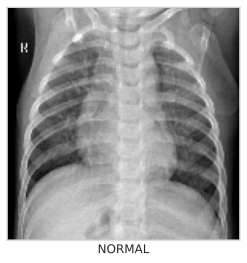

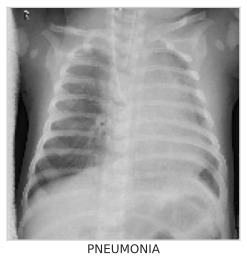

In [67]:
# Healthy Lung
plt.figure(figsize=(4,4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset_train[0][0])
plt.xlabel(labels[dataset_train[0][1]])

# lung with pneumonia
plt.figure(figsize=(4,4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset_train[-1][0])
plt.xlabel(labels[dataset_train[-1][1]])

In [68]:
# function to normalize the pixels
f_norm = lambda x: (np.array(x) / 255.0).astype('float32')

x_train = f_norm(x_train_ini)
x_valid = f_norm(x_valid_ini)
x_test = f_norm(x_test_ini)

# shape:
print('Shape x_train: {} \nShape x_valid: {} \nShape x_test: {}'.format(
    x_train.shape, x_valid.shape, x_test.shape))

Shape x_train: (5216, 150, 150, 3) 
Shape x_valid: (16, 150, 150, 3) 
Shape x_test: (624, 150, 150, 3)


In [72]:
# function to convert to array
fc = lambda x: np.array(x)

x_train = fc(x_train)
y_train = fc(y_train)
x_valid = fc(x_valid)
y_valid = fc(y_valid)
x_test = fc(x_test)
y_test = fc(y_test)

In [116]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = False,
            rotation_range = 0.05,
            zca_whitening = False,
            width_shift_range = 0.05,
            height_shift_range = 0.05,
            channel_shift_range = 0.05,
            shear_range = 0.05,
            zoom_range = 0.05)

# simple data generator for validation and training
val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(dir_train, class_mode = "binary", batch_size = 32, target_size = (150, 150))
validation_set = val_test_datagen.flow_from_directory(dir_valid, class_mode = "binary", batch_size = 32, target_size = (150, 150))
test_set = val_test_datagen.flow_from_directory(dir_test, class_mode = "binary", batch_size = 32, target_size = (150, 150))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


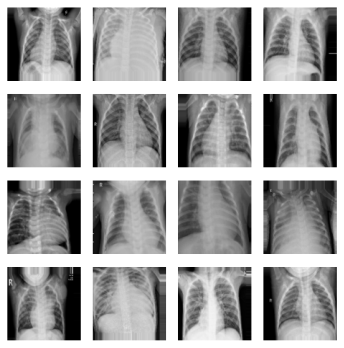

In [103]:
# Plot augmented images
# This code was written with help from chatgpt
# Create a 4x4 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))

# Iterate over the images and plot them in the grid
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(train_set.next()[0][i * 4 + j])  # Assuming grayscale images
        axes[i, j].axis('off')  # Turn off axis labels

# Adjust layout to prevent clipping of subplot titles
plt.tight_layout()

# Show the plot
plt.show()

## CNN model

In [156]:
model1 = keras.models.Sequential()
# CNN layers with batchnorm, pooling and dropout for feature extraction
model1.add(Conv2D(32, (3,3), strides = 1, padding='same', activation='relu', input_shape=(150,150,3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2), strides=2, padding='same'))
model1.add(Conv2D(64, (3,3), strides=1 ,padding='same', activation='relu'))
model1.add(Dropout(0.1))
model1.add(BatchNormalization())

model1.add(MaxPool2D((2,2), strides=2, padding='same'))
model1.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2), strides=2, padding='same'))
model1.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

model1.add(MaxPool2D((2,2), strides=2, padding='same'))
model1.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())

# fully connected layers for classification
model1.add(MaxPool2D((2,2), strides=2, padding='same'))
model1.add(Flatten())
model1.add(Dense(units=128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1, activation='sigmoid'))

In [157]:
# compiling the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_35 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_28 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_36 (Ba  (None, 75, 75, 64)      

In [158]:
# defining early stopping
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [159]:
# learning rate scheduling
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [160]:
# training custom model
history = model1.fit(
train_set, batch_size=32, shuffle=True,epochs=10, validation_data = validation_set, callbacks=[early_stopping_callbacks])

Epoch 1/10


2023-12-14 01:34:46.375242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 66s 383ms/step - loss: 0.2499 - accuracy: 0.9164 - val_loss: 14.5067 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 63s 384ms/step - loss: 0.1277 - accuracy: 0.9530 - val_loss: 14.2093 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 62s 382ms/step - loss: 0.1136 - accuracy: 0.9590 - val_loss: 0.8785 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 63s 385ms/step - loss: 0.1116 - accuracy: 0.9599 - val_loss: 3.1282 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 63s 384ms/step - loss: 0.1066 - accuracy: 0.9622 - val_loss: 0.4315 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 62s 382ms/step - loss: 0.0967 - accuracy: 0.9645 - val_loss: 1.6040 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 62s 382ms/step - loss: 0.0959 - accuracy: 0.9676 - val_loss: 1.0941 - val_accuracy: 0

In [161]:
def make_plot(history,model):
#   made with help from chatgpt 
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

    # Plot on the first subplot
    axes[0].plot(history.history["loss"], "go-")
    axes[0].plot(history.history["val_loss"], "ro-")
    axes[0].set_title(f'{model} loss', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=16)
    axes[0].set_ylabel('Loss', fontsize=16)
    axes[0].legend(["train_loss", "val_loss"], fontsize=14)

    # Plot on the second subplot
    axes[1].plot(history.history["accuracy"], "go-")
    axes[1].plot(history.history["val_accuracy"], "ro-")
    axes[1].set_title(f'{model} accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=16)
    axes[1].set_ylabel('Accuracy', fontsize=16)
    axes[1].legend(["train_accuracy", "val_accuracy"], fontsize=14)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [162]:
# print test scores
scores = model1.evaluate(x_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.82%


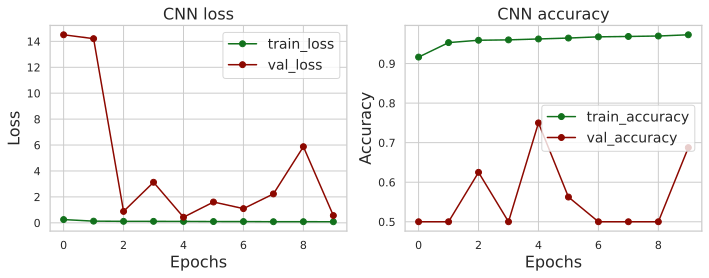

In [163]:
# plotting scores of CNN model
make_plot(history,"CNN")

CNN Confusion Matrix : 

20/20 [==============================] - 0s 7ms/step


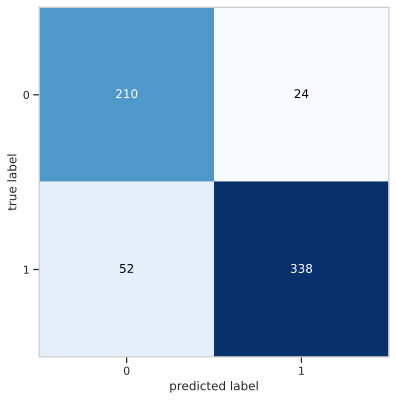

In [164]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# creating confusion matrix for CNN
print("CNN Confusion Matrix : \n")

predictions = model1.predict(x_test)
conf_m = confusion_matrix(y_test, np.round(predictions))
acc = accuracy_score(y_test, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [165]:
# generating evaluation metrics for CNN
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 87.82051282051282%
Precision: 93.37016574585635%
Recall: 86.66666666666667%
F1-score: 89.89361702127658


In [166]:
del model1
del history

## Pre-trained VGG16

In [128]:
# loading pre-trained vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np


base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (150, 150, 3), pooling = "max",
                    classes = 2)

In [129]:
# training vgg16 model
# Freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation="relu"))
model2.add(Dense(64, activation="relu"))
model2.add(Dense(32, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model2.summary()

history2 = model2.fit(
    train_set, batch_size=32, shuffle=True, epochs=10,
    validation_data=validation_set, callbacks=[early_stopping_callbacks]
)


# base_model1 = VGG16(include_top=False, weights="imagenet", input_shape=(150, 150, 3), pooling="max")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               65664     
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14790721 (56.42 MB)
Trainable params: 7

In [130]:
# test score of vgg16
test_loss, test_accuracy = model2.evaluate(x_test, y_test, verbose=0)
print("The testing accuracy is: ", test_accuracy * 100, "%")

The testing accuracy is:  85.25640964508057 %


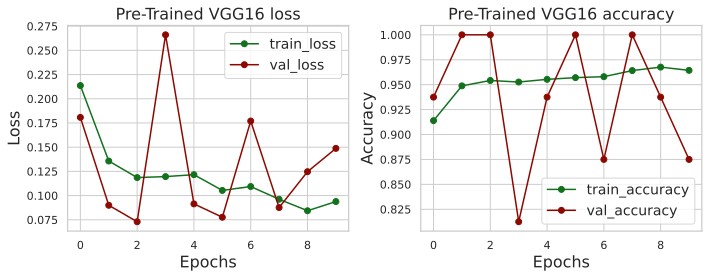

In [131]:
# plotting scores of vgg16
make_plot(history2,"Pre-Trained VGG16")

Pre-trained VGG Confusion Matrix : 

20/20 [==============================] - 1s 34ms/step


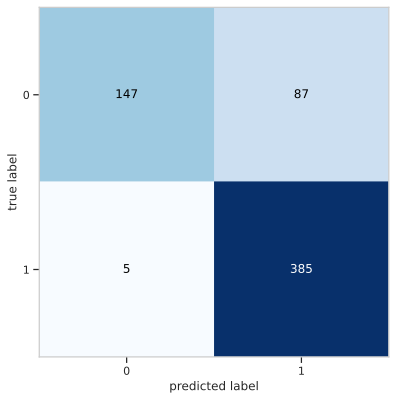

In [134]:
# creating confusion matrix for vgg16
print("Pre-trained VGG Confusion Matrix : \n")

predictions = model2.predict(x_test)
conf_m = confusion_matrix(y_test, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [135]:
# generating evaluation metrics for vgg16
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 85.25641025641025%
Precision: 81.5677966101695%
Recall: 98.71794871794873%
F1-score: 89.32714617169374


In [136]:
del model2
del history2

## Pre-trained ResNET50V2

In [137]:
# loading pre-trained resnet50V2 model
base_model2 = tf.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (150, 150, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
# compiling resnet50v2 model
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_38 (Dense)            (None, 128)               262272    
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23837441 (90.93 MB)
Trainable params: 2

In [138]:
# training resnet50v2 model
history3 = model3.fit(
    train_set, batch_size=32, shuffle=True, epochs=10,
    validation_data=validation_set, callbacks=[early_stopping_callbacks]
)

Epoch 1/10
163/163 [==============================] - 68s 391ms/step - loss: 0.2086 - accuracy: 0.9239 - val_loss: 0.1758 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 62s 382ms/step - loss: 0.1237 - accuracy: 0.9517 - val_loss: 0.4550 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 62s 380ms/step - loss: 0.1063 - accuracy: 0.9595 - val_loss: 0.3279 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 62s 381ms/step - loss: 0.0965 - accuracy: 0.9603 - val_loss: 0.4225 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 62s 379ms/step - loss: 0.0955 - accuracy: 0.9641 - val_loss: 0.2931 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 62s 380ms/step - loss: 0.0943 - accuracy: 0.9620 - val_loss: 0.5077 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 62s 380ms/step - loss: 0.0889 - accuracy: 0.9664 - val_loss: 0.5051 - val_ac

In [139]:
# test score of resnet50v2
test_loss, test_accuracy = model3.evaluate(x_test, y_test, verbose=0)
print("The testing accuracy is: ", test_accuracy * 100, "%")

The testing accuracy is:  85.25640964508057 %


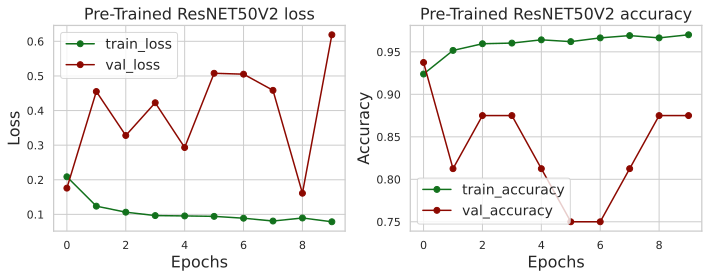

In [140]:
# plot resnet50v2 test scores
make_plot(history3,"Pre-Trained ResNET50V2")

Pre-trained ResNet Confusion Matrix : 

20/20 [==============================] - 1s 30ms/step


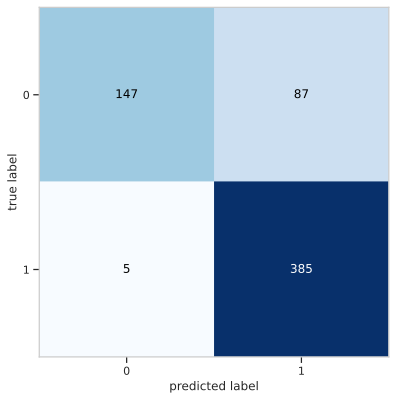

In [141]:
# creating confusion matrix for resnet50v2
print("Pre-trained ResNet Confusion Matrix : \n")

predictions = model3.predict(x_test)
conf_m = confusion_matrix(y_test, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [142]:
# generating evaluation metrics for resnet50v2
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 85.25641025641025%
Precision: 81.5677966101695%
Recall: 98.71794871794873%
F1-score: 89.32714617169374


In [143]:
del model3
del history3

## Fully-trained VGG16

In [144]:
# loading untrained vgg16 model
base_model3 = VGG16(include_top = False, weights = None, input_shape = (150, 150, 3), pooling = "max",
                    classes = 2)

# Freeze the layers
for layer in base_model3.layers:
    layer.trainable = True

model4 = Sequential()
model4.add(base_model3)
model4.add(Flatten())

model4.add(Dense(128, activation="relu"))
model4.add(Dense(64, activation="relu"))
model4.add(Dense(32, activation="relu"))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model4.summary()

history4 = model4.fit(
    train_set, batch_size=32, shuffle=True, epochs=10,
    validation_data=validation_set, callbacks=[early_stopping_callbacks]
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_14 (Flatten)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               65664     
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 32)                2080      
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14790721 (56.42 MB)
Trainable params: 1

In [145]:
# test score of vgg16
test_loss, test_accuracy = model4.evaluate(x_test, y_test, verbose=0)
print("The testing accuracy is: ", test_accuracy * 100, "%")

The testing accuracy is:  62.5 %


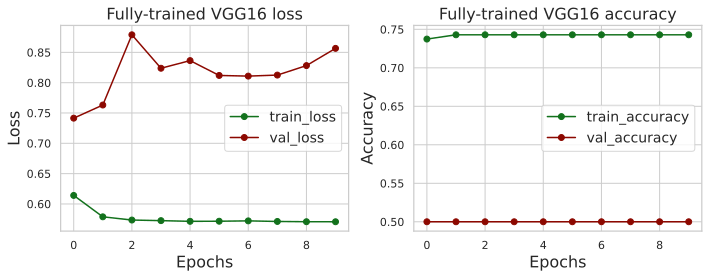

In [146]:
# plotting scores of vgg16
make_plot(history4,"Fully-trained VGG16")

Fully-trained VGG Confusion Matrix : 

20/20 [==============================] - 1s 33ms/step


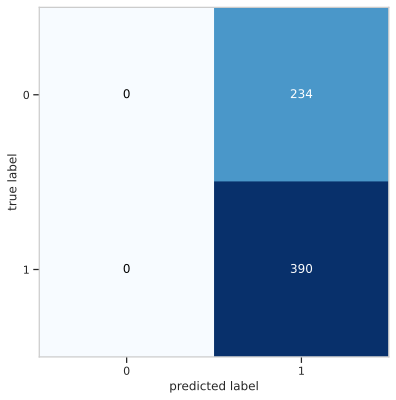

In [147]:
# creating confusion matrix for vgg16
print("Fully-trained VGG Confusion Matrix : \n")

predictions = model4.predict(x_test)
conf_m = confusion_matrix(y_test, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [148]:
# generating evaluation metrics for vgg16
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 62.5%
Precision: 62.5%
Recall: 100.0%
F1-score: 76.92307692307692


In [149]:
del model4
del history4

## Fully-trained resnet50v2

In [150]:
# loading pre-trained resnet50V2 model
base_model4 = tf.keras.applications.ResNet50V2(weights = None,
                                                       input_shape = (150, 150, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model4.layers:
    layer.trainable = True
    
# compiling resnet50v2 model
model5 = Sequential()
model5.add(base_model4)
model5.add(Flatten())

model5.add(Dense(128, activation = "relu"))
model5.add(Dense(64, activation = "relu"))
model5.add(Dense(32, activation = "relu"))
model5.add(Dense(1, activation = "sigmoid"))

model5.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model5.summary()

# training resnet50v2 model
history5 = model5.fit(
    train_set, batch_size=32, shuffle=True, epochs=10,
    validation_data=validation_set, callbacks=[early_stopping_callbacks]
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_46 (Dense)            (None, 128)               262272    
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23837441 (90.93 MB)
Trainable params: 2

In [151]:
# test score of resnet50v2
test_loss, test_accuracy = model5.evaluate(x_test, y_test, verbose=0)
print("The testing accuracy is: ", test_accuracy * 100, "%")

The testing accuracy is:  83.33333134651184 %


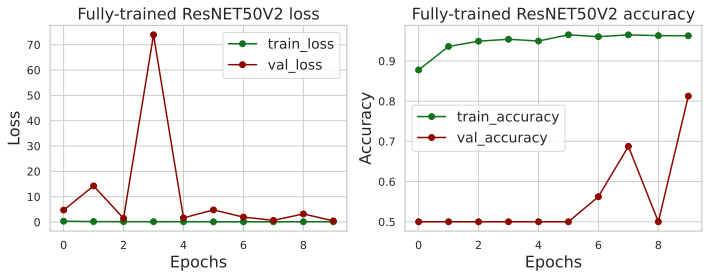

In [152]:
# plot resnet50v2 test scores
make_plot(history5,"Fully-trained ResNET50V2")

Fully-trained ResNet Confusion Matrix : 

20/20 [==============================] - 1s 30ms/step


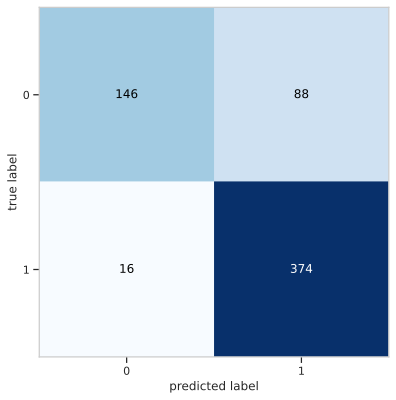

In [153]:
# creating confusion matrix for resnet50v2
print("Fully-trained ResNet Confusion Matrix : \n")

predictions = model5.predict(x_test)
conf_m = confusion_matrix(y_test, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = plt.cm.Blues)
plt.show()

In [154]:
# generating evaluation metrics for resnet50v2
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 83.33333333333334%
Precision: 80.95238095238095%
Recall: 95.8974358974359%
F1-score: 87.79342723004694


In [155]:
del model5
del history5